### Read in packages

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

### Read in Boston data

In [2]:
boston_cal_df = pd.read_csv('data/boston-airbnb-open-data/calendar.csv',parse_dates=True)
boston_listings_df = pd.read_csv('data/boston-airbnb-open-data/listings.csv',parse_dates=True)
boston_reviews_df = pd.read_csv('data/boston-airbnb-open-data/reviews.csv')


#Convert the date column to a date time type
boston_cal_df['new_date'] = pd.to_datetime(boston_cal_df['date']).dt.normalize()

boston_cal_df = boston_cal_df.drop('date', axis = 1)

#Remove $ from strings

boston_cal_df['price'].replace(regex=True,inplace=True,to_replace=r'\$',value=r'')
boston_cal_df['price'].replace(regex=True,inplace=True,to_replace=r'\,',value=r'')

#convert price column to a float type
boston_cal_df['new_price'] = pd.to_numeric(boston_cal_df['price'])

boston_cal_df = boston_cal_df.drop('price', axis = 1)

In [3]:
print('The calendar data contains', len(boston_cal_df.columns.tolist()), 
      'columns. The are called')

for col in boston_cal_df.columns.tolist():
          print(col)

The calendar data contains 4 columns. The are called
listing_id
available
new_date
new_price


In [4]:
missing_prices = round((len(
    boston_cal_df['new_price'][boston_cal_df['new_price'].isnull()])/len(boston_cal_df['new_price'])*100
                       ),2)

unique_listings = len(boston_cal_df['listing_id'].unique())

early = min(boston_cal_df['new_date'])
late = max(boston_cal_df['new_date'])

print('From the above we can see that there are', 
      unique_listings, 'unique listings.\n', 
      missing_prices,'% of the pices are missing too.\n',
     'This data ranges from', early, 'to', late)


From the above we can see that there are 3585 unique listings.
 50.87 % of the pices are missing too.
 This data ranges from 2016-09-06 00:00:00 to 2017-09-05 00:00:00


In [5]:
price_null = boston_cal_df[['listing_id',
                            'new_date',
                            'available',
                            'new_price']][boston_cal_df['new_price'].isnull()]


price_not_null = boston_cal_df[['listing_id',
                                'new_date',
                                'available',
                                'new_price']][boston_cal_df['new_price'].notnull()]


In [6]:
price_null['available'].unique()

array(['f'], dtype=object)

In [7]:
price_not_null['available'].unique()

array(['t'], dtype=object)

### From the above two cells it seems that when the price is null, the availibility column is f. When the price is not null the availability is t. This would seem to sugest that t stands for',true and f stands for false. Now I will replace t with 1 and f with 0.

In [8]:
old_avail = boston_cal_df[['available']]
boston_cal_df['new_available'] = old_avail.replace(['f','t'],[0,1])
boston_cal_df = boston_cal_df.drop('available', axis =1)

### What is the distribution of prices?

In [9]:
date_price_df = boston_cal_df[[
    'new_date',
    'new_price']].groupby([
    'new_date']).mean().reset_index(level=['new_date'])



/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


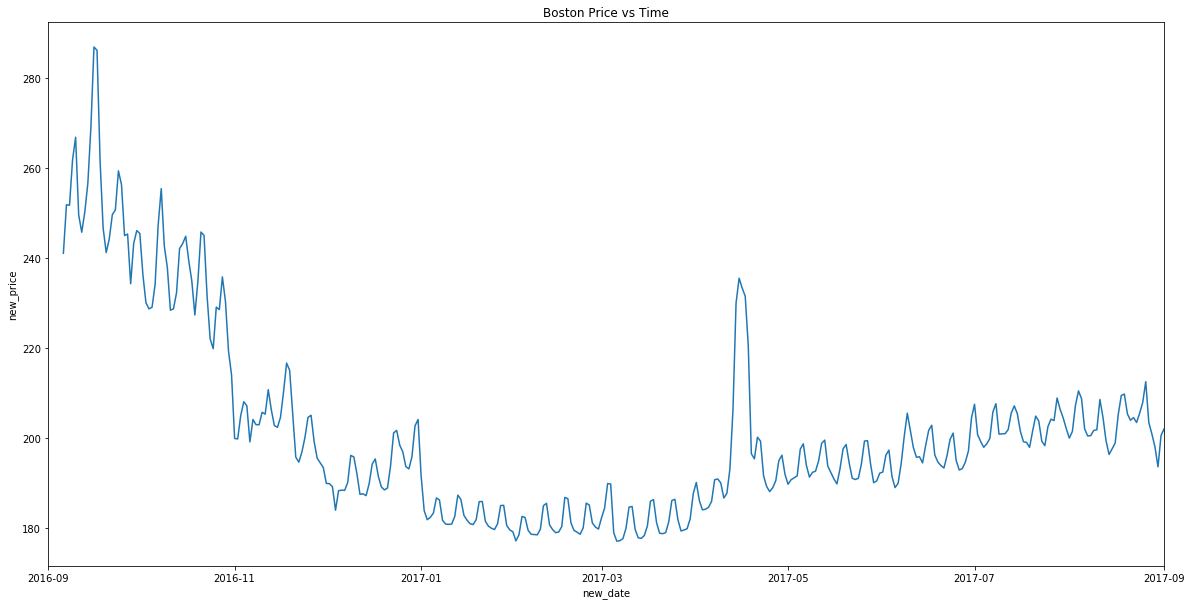

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x='new_date', y='new_price', data=date_price_df)
plt.title('Boston Price vs Time')
ax.set(xlim = ('2016-09-01', '2017-09-01'))
plt.show();

# What is that huge spike?

In [11]:
spike_range = date_price_df[(date_price_df['new_date'] >= '2017-04-01') & 
                            (date_price_df['new_date'] <= '2017-05-01')]

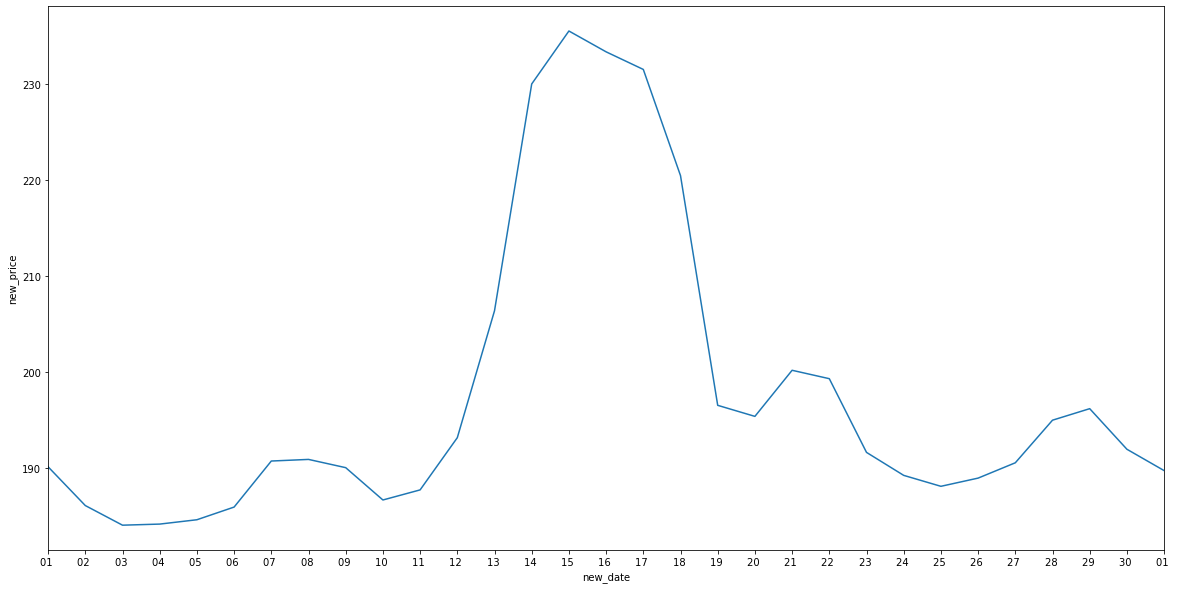

In [12]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x='new_date', y='new_price', data=spike_range)
ax.set(xlim = ('2017-04-01', '2017-05-01'))
ax.xaxis.set_major_locator(mdates.DayLocator())

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d '));

### The big spike between the 13th and 19th of april 2017 with a maximum on the 15th April 2017, (https://www.officeholidays.com/countries/usa/massachusetts/2017) is due to Patriots' Day weekend. From wikipedia (https://en.wikipedia.org/wiki/Patriots%27_Day) this marks the Battles of Lexington and Concord\, and the Battle of Menotomy which were the first two battles of the reviolutionary war.

# How do prices vary by day of the week?

In [13]:
round(date_price_df.groupby(date_price_df['new_date'].dt.weekday_name).mean().sort_values(by = 'new_price'),2)

,new_price
new_date,
Tuesday,197.60
Monday,197.81
Wednesday,197.83
Sunday,200.74
Thursday,200.88
Friday,206.43
Saturday,206.93


### there is a slight increase in price from mondays-wednesdays compared to friday-sunday. Which makes sense as people like to go on holiday on weekends

# How many of each property type are there?

In [14]:
prop_type_df = boston_listings_df['property_type'].value_counts()

In [18]:
prop_type_df

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

## So we can see that of the 3582 properties 2612 (73%) are appartments with the next largest being Houses which acount for 562 (15%)

# What is the distribution of reviews in boston?

In [74]:
round(boston_listings_df['review_scores_value'][boston_listings_df['review_scores_value'].notnull()].value_counts(normalize=True)*100,1)

10.0    42.6
9.0     40.9
8.0     12.1
7.0      1.8
6.0      1.8
4.0      0.4
2.0      0.3
5.0      0.1
3.0      0.1
Name: review_scores_value, dtype: float64

### so over 80% of reviews are 9-10 out of 10